In [42]:
import pytensor 
import pymc as pm
import arviz as az
import jax
import jax.numpy as jnp
import pyhf
pyhf.set_backend('jax')

import numpy as np
import matplotlib.pyplot as plt
import json
import time

from pytensor import tensor as pt
from pytensor.graph.basic import Apply

# Bayesian inference for ttbar / Displaced Leptons

We perform some prior-predictive checks for [this measurement of the ttbar production cross section](https://www.hepdata.net/record/ins1869695) and [this search for displaced leptons](https://www.hepdata.net/record/resource/1981552?landing_page=true) measurement.

### Set-Up
 ... pyhf model set-up.

In [47]:
### Choose the right .json file
n = "ttbar"

if n == "ttbar":
    with open("ttbar_ljets_xsec_inclusive_pruned.json") as serialized:
        spec = json.load(serialized)
    nBins = 37

if n == "DisplacedLeptons":
    with open("/Users/malinhorstmann/Documents/pyhf_pymc/PPC/SRee_SRmm_Srem.json") as serialized:
        spec = json.load(serialized)
    nBins = 3


### Create pyhf model from it
workspace = pyhf.Workspace(spec)

model = workspace.model()

### Observations
obs = workspace.data(model, include_auxdata=False)


... print the specifications.

In [ ]:
print(f"channels: {model.config.channels}")
print(".........")
print(f"nbins: {model.config.channel_nbins}")
print(".........")
print(f"samples: {model.config.samples}")
print(".........")
print(f"modifiers: {model.config.modifiers}")
print(".........")
print(f"parameters: {model.config.parameters}")
print(".........")
print(f"nauxdata: {model.config.nauxdata}")
print(".........")
print(f"auxdata: {model.config.auxdata}")

### Class

... Op creation.

In [44]:
### Class that creates the model Op
class Op(pt.Op):
    itypes = [pt.dvector]  # Expects a vector of parameter values
    otypes = [pt.dvector]  # Outputs a vector of values (the model.expected_actualdata)

    def __init__(self, name, func):
        ## Add inputs as class attributes
        self.func = func
        self.name = name

    def perform(self, node, inputs, outputs):
        ## Method that is used when calling the Op
        (theta,) = inputs  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = self.func(theta)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

## Include posteriors 

... trade-off with then number of draws and parameters, as computation breaks down for larger values of them.

In [48]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Specs
nPars = 8
N_prior = 500
N_posterior = 500

prior = "gamma"

mu = 1
sigma = 0.1
alBet = 40

### Opening the pyMC model space
start_time = time.time()
with pm.Model() as basic_model:
    ## TensorVar input parameters
    pars = []
    pars.extend(pm.Gamma(f"{model.config.parameters[idx]}", alpha=20, beta=20) for idx in range(nPars))
    pars = pt.as_tensor_variable(pars)

    main = pm.Poisson("main", mu=mainOp(pars), observed=obs)

    ## Sampling ...
    post_data = pm.sample(N_posterior)
    prior_data = pm.sample_prior_predictive(N_prior)
    post_pred = pm.sample_posterior_predictive(post_data)

print("...............................................")
# print(f"That took {(time.time() - start_time)/60} minutes ...")
dummyTime = round(time.time() - start_time, 3)
print(f"That took {dummyTime} seconds ...")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [JET_BJES_Response]
>Slice: [JET_EffectiveNP_Detector1]
>Slice: [JET_EffectiveNP_Mixed1]
>Slice: [JET_EffectiveNP_Mixed2]
>Slice: [JET_EffectiveNP_Modelling1]
>Slice: [JET_EffectiveNP_Modelling2]
>Slice: [JET_EffectiveNP_Modelling3]
>Slice: [JET_EffectiveNP_Statistical1]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 16 seconds.
Sampling: [JET_BJES_Response, JET_EffectiveNP_Detector1, JET_EffectiveNP_Mixed1, JET_EffectiveNP_Mixed2, JET_EffectiveNP_Modelling1, JET_EffectiveNP_Modelling2, JET_EffectiveNP_Modelling3, JET_EffectiveNP_Statistical1, main]
Sampling: [main]


...............................................
That took 18.712 seconds ...


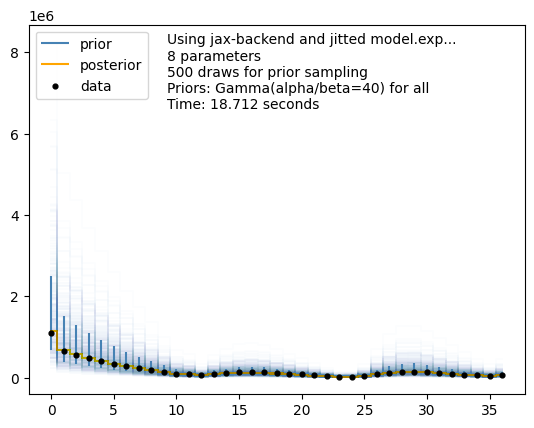

In [49]:
### Plotting ...
    ## Prior predictive
plt.step(np.linspace(0,nBins-1,nBins),prior_data.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_data.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label="prior");
    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label="posterior")
    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

y = 0.8*prior_data.prior_predictive.main[0].max().values
x = nBins / 4

if prior == "normal":
    plt.text(x, y, f'Using jax-backend and jitted model.exp... \n{nPars} parameters \n{N_prior} draws for prior sampling \nPriors: Normal(mu={mu},sig={sigma}) for all \nTime: {dummyTime} seconds', fontsize = 10)
    # plt.savefig(f'ttbar_plots/priors_only/ttbar_Norm{mu}_{sigma}_nPrior{N_prior}_nPars{nPars}.pdf')
if prior == "gamma":
    plt.text(x, y, f'Using jax-backend and jitted model.exp... \n{nPars} parameters \n{N_prior} draws for prior sampling \nPriors: Gamma(alpha/beta={alBet}) for all \nTime: {dummyTime} seconds', fontsize = 10)
    # plt.savefig(f'ttbar_plots/priors_only/ttbar_Gamma{alBet}_nPrior{N_prior}_nPars{nPars}.pdf')

## Only prior-predictive checks

... can use reasonable values for the numer of draws and parameters

In [50]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Specs
nPars = 9
N_prior = 500

prior = "gamma"

mu = 1
sigma = 0.1
alBet = 40

### Opening the pyMC model space
start_time = time.time()
with pm.Model() as basic_model:
    ## TensorVar input parameters
    pars = []
    if prior == "gamma":
        pars.extend(pm.Gamma(f"{model.config.parameters[idx]}", alpha=alBet, beta=alBet) for idx in range(nPars))
    if prior == "normal":
        pars.extend(pm.Normal(f"{model.config.parameters[idx]}", mu=mu, sigma=sigma) for idx in range(nPars))
    pars = pt.as_tensor_variable(pars)

    ## Model for model.expected_actualdata()
    mainPoiss = pm.Poisson("mainPoiss", mu=mainOp(pars), observed=obs)

    ## Sampling ...
    # post_data = pm.sample(5)
    prior_data = pm.sample_prior_predictive(N_prior)
    # post_pred = pm.sample_posterior_predictive(post_data)

print("...............................................")
# print(f"That took {(time.time() - start_time)/60} minutes ...")
dummyTime = round(time.time() - start_time, 3)
print(f"That took {dummyTime} seconds ...")

Sampling: [JET_BJES_Response, JET_EffectiveNP_Detector1, JET_EffectiveNP_Mixed1, JET_EffectiveNP_Mixed2, JET_EffectiveNP_Modelling1, JET_EffectiveNP_Modelling2, JET_EffectiveNP_Modelling3, JET_EffectiveNP_Statistical1, JET_EffectiveNP_Statistical2, mainPoiss]


...............................................
That took 0.335 seconds ...


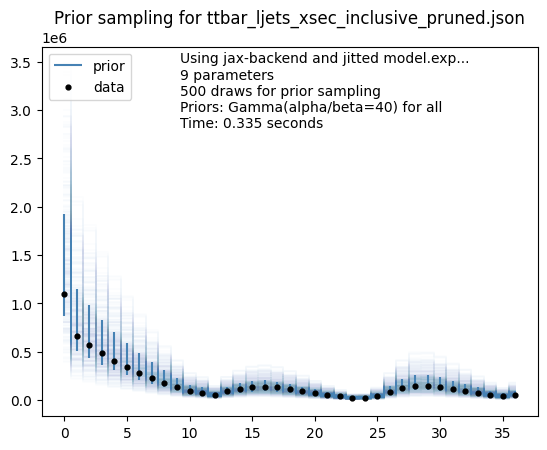

In [52]:
### Plotting ...
    ## Prior predictive
plt.step(np.linspace(0,nBins-1,nBins),prior_data.prior_predictive.mainPoiss[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_data.prior_predictive.mainPoiss[0],[.15,.85],axis=0), colors = 'steelblue', label="prior");
    ## Posterior predictive
# plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.mainPoiss[0].T, alpha = 0.01, c = 'orange', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.mainPoiss[0],[.15,.85],axis=0), colors = 'orange', label="posterior")
    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title("Prior sampling for ttbar_ljets_xsec_inclusive_pruned.json")

y = 0.81*prior_data.prior_predictive.mainPoiss[0].max().values
x = nBins/4

if prior == "normal":
    plt.text(x, y, f'Using jax-backend and jitted model.exp... \n{nPars} parameters \n{N_prior} draws for prior sampling \nPriors: Normal(mu={mu},sig={sigma}) for all \nTime: {dummyTime} seconds', fontsize = 10)
    # plt.savefig(f'ttbar_plots/priors_only/ttbar_Norm{mu}_{sigma}_nPrior{N_prior}_nPars{nPars}.pdf')
if prior == "gamma":
    plt.text(x, y, f'Using jax-backend and jitted model.exp... \n{nPars} parameters \n{N_prior} draws for prior sampling \nPriors: Gamma(alpha/beta={alBet}) for all \nTime: {dummyTime} seconds', fontsize = 10)
    # plt.savefig(f'ttbar_plots/priors_only/ttbar_Gamma{alBet}_nPrior{N_prior}_nPars{nPars}.pdf')